Anggota Kelompok : <P>
Nanda Pratama 22.11.4623<p>
Ikhwanur Abdillah 22.11.4632<p>
Yuli Dwi Kurniawan 22.11.4675<p>


# --- Import Libraries ---

In [ ]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, when, isnan, count
from pyspark.ml.feature import VectorAssembler, StringIndexer, MinMaxScaler
from pyspark.ml.classification import RandomForestClassifier, GBTClassifier, LogisticRegression, MultilayerPerceptronClassifier
from pyspark.ml.evaluation import BinaryClassificationEvaluator, MulticlassClassificationEvaluator
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# --- Load Dataset ---

In [ ]:
#membuat Spark Session
spark = SparkSession.builder.appName("Chronic Kidney Disease Analysis").getOrCreate()

#Load dataset
data_path = "kidney_disease.csv"
kidney_df = spark.read.csv(data_path, header=True, inferSchema=True)

#Display Dataset
kidney_df.printSchema()
kidney_df.show(5)


root
 |-- id: integer (nullable = true)
 |-- age: double (nullable = true)
 |-- bp: double (nullable = true)
 |-- sg: double (nullable = true)
 |-- al: double (nullable = true)
 |-- su: double (nullable = true)
 |-- rbc: string (nullable = true)
 |-- pc: string (nullable = true)
 |-- pcc: string (nullable = true)
 |-- ba: string (nullable = true)
 |-- bgr: double (nullable = true)
 |-- bu: double (nullable = true)
 |-- sc: double (nullable = true)
 |-- sod: double (nullable = true)
 |-- pot: double (nullable = true)
 |-- hemo: double (nullable = true)
 |-- pcv: string (nullable = true)
 |-- wc: string (nullable = true)
 |-- rc: string (nullable = true)
 |-- htn: string (nullable = true)
 |-- dm: string (nullable = true)
 |-- cad: string (nullable = true)
 |-- appet: string (nullable = true)
 |-- pe: string (nullable = true)
 |-- ane: string (nullable = true)
 |-- classification: string (nullable = true)

+---+----+----+-----+---+---+------+--------+----------+----------+-----+----+---+

# --- Data Preprocessing ---

In [ ]:
# Handle missing values
missing_values = kidney_df.select([(count(when(isnan(c) | col(c).isNull(), c)) / kidney_df.count()).alias(c) for c in kidney_df.columns])
missing_values.show()

# Drop rows with many missing values and fill others
kidney_df = kidney_df.dropna(how='any')

# Encode categorical features
categorical_cols = [c for c in kidney_df.columns if kidney_df.select(c).dtypes[0][1] == 'string']
indexers = [StringIndexer(inputCol=col, outputCol=f"{col}_indexed") for col in categorical_cols]
for indexer in indexers:
    kidney_df = indexer.fit(kidney_df).transform(kidney_df)

# Select features and target
feature_cols = [c for c in kidney_df.columns if c not in ['classification'] + categorical_cols]
target_col = 'classification_indexed'
assembler = VectorAssembler(inputCols=feature_cols, outputCol="features")
kidney_df = assembler.transform(kidney_df)

# Scale features
scaler = MinMaxScaler(inputCol="features", outputCol="scaledFeatures")
kidney_df = scaler.fit(kidney_df).transform(kidney_df)

# Convert to Pandas DataFrame for easier visualization
kidney_pd = kidney_df.toPandas()

+---+------+----+------+-----+------+----+------+----+----+----+------+------+------+----+----+-----+------+-----+-----+-----+-----+------+------+------+--------------+
| id|   age|  bp|    sg|   al|    su| rbc|    pc| pcc|  ba| bgr|    bu|    sc|   sod| pot|hemo|  pcv|    wc|   rc|  htn|   dm|  cad| appet|    pe|   ane|classification|
+---+------+----+------+-----+------+----+------+----+----+----+------+------+------+----+----+-----+------+-----+-----+-----+-----+------+------+------+--------------+
|0.0|0.0225|0.03|0.1175|0.115|0.1225|0.38|0.1625|0.01|0.01|0.11|0.0475|0.0425|0.2175|0.22|0.13|0.175|0.2625|0.325|0.005|0.005|0.005|0.0025|0.0025|0.0025|           0.0|
+---+------+----+------+-----+------+----+------+----+----+----+------+------+------+----+----+-----+------+-----+-----+-----+-----+------+------+------+--------------+



# --- Exploratory Data Analysis (EDA) ---

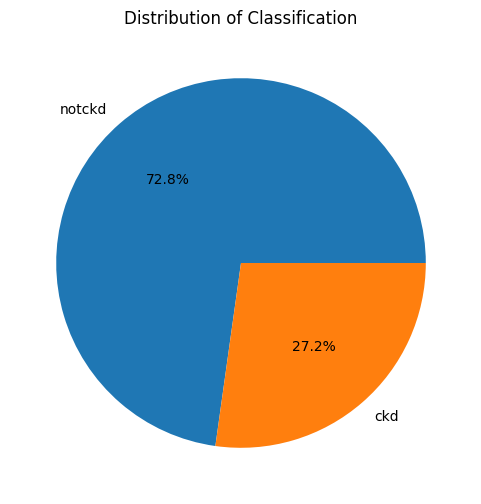

In [ ]:
# Visualisasi 1: Distribusi target (pie chart)
kidney_pd['classification'].value_counts().plot(kind='pie', autopct='%1.1f%%', colors=['lightblue', 'salmon'])
plt.title('Distribusi Target')
plt.ylabel('')
plt.show()

<ipython-input-7-e09f55bfebef>:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=kidney_pd, x='htn', palette='pastel')


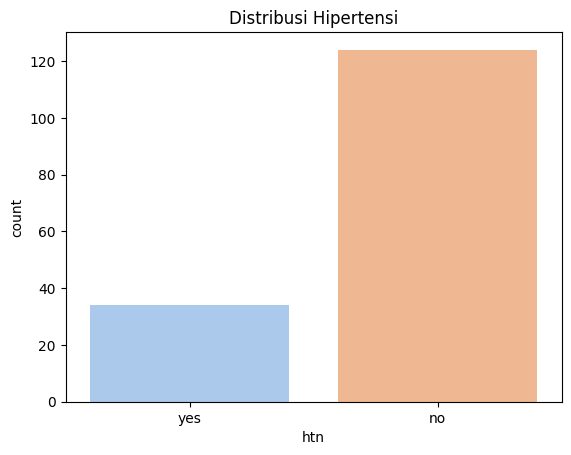

In [ ]:
# Visualisasi 2: Bar chart untuk hipertensi
sns.countplot(data=kidney_pd, x='htn', palette='pastel')
plt.title('Distribusi Hipertensi')
plt.show()

<ipython-input-8-f869aa7f933b>:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=kidney_pd, x='classification', y='age', palette='coolwarm')


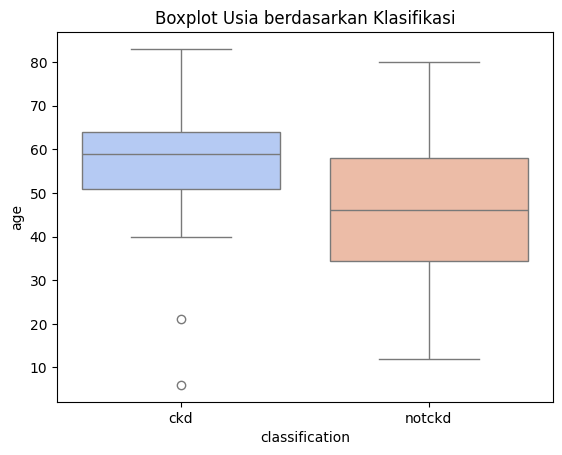

In [ ]:
# Visualisasi 3: Boxplot kolom numerik tertentu
sns.boxplot(data=kidney_pd, x='classification', y='age', palette='coolwarm')
plt.title('Boxplot Usia berdasarkan Klasifikasi')
plt.show()

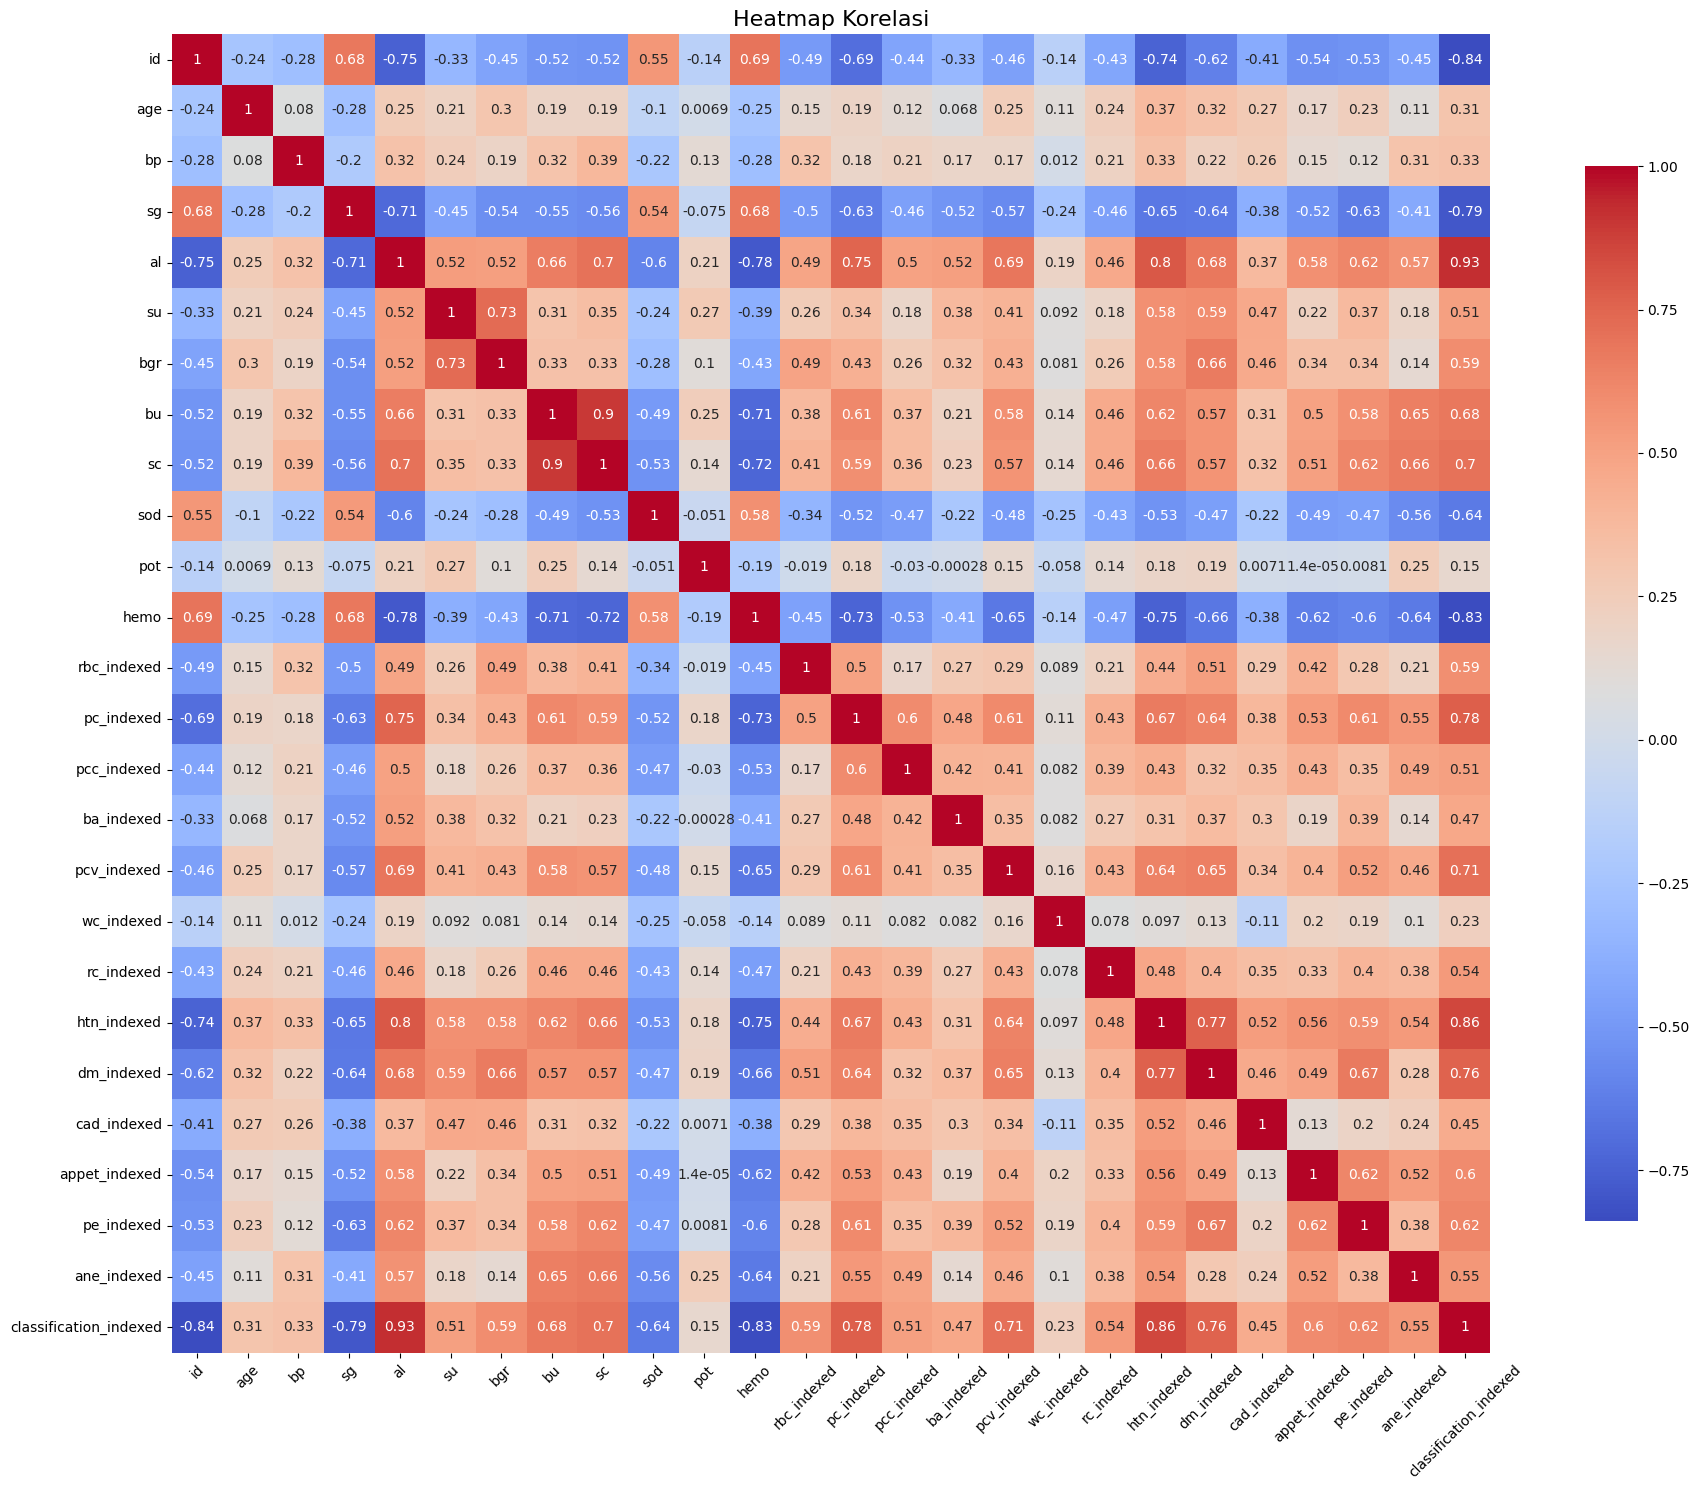

In [ ]:
# Visualisasi 4: Heatmap korelasi
numerical_data = kidney_pd.select_dtypes(include=['number'])
numerical_data = numerical_data.dropna()
correlation_matrix = numerical_data.corr()
plt.figure(figsize=(20, 15))  # Ukuran figure
sns.heatmap(
    correlation_matrix,
    annot=True,
    cmap='coolwarm',
    cbar_kws={'shrink': 0.8},  # Ukuran colorbar
    annot_kws={"size": 10},    # Ukuran font annotasi
    square=True                # Membuat sel persegi
)
plt.xticks(rotation=45)  # Rotasi label x-axis
plt.yticks(rotation=0)   # Rotasi label y-axis
plt.title('Heatmap Korelasi', fontsize=16)  # Ukuran font judul
plt.tight_layout()  # Atur tata letak otomatis
plt.show()


In [ ]:
#Split Dataset into Train and Test
train_df, test_df = kidney_df.randomSplit([0.8, 0.2], seed=42)

# --- Modeling ---

In [ ]:
# Define models
models = {
    "Random Forest": RandomForestClassifier(featuresCol="scaledFeatures", labelCol=target_col),
    "Gradient Boosted Trees": GBTClassifier(featuresCol="scaledFeatures", labelCol=target_col),
    "Logistic Regression": LogisticRegression(featuresCol="scaledFeatures", labelCol=target_col),
    "Multilayer Perceptron": MultilayerPerceptronClassifier(featuresCol="scaledFeatures", labelCol=target_col, layers=[len(feature_cols), 16, 2])
}

In [ ]:
# Evaluate models
results = []
for name, model in models.items():
    fitted_model = model.fit(train_df)
    predictions = fitted_model.transform(test_df)

    evaluator = BinaryClassificationEvaluator(labelCol=target_col)
    auc = evaluator.evaluate(predictions)

    multi_evaluator = MulticlassClassificationEvaluator(labelCol=target_col)
    accuracy = multi_evaluator.evaluate(predictions, {multi_evaluator.metricName: "accuracy"})
    f1 = multi_evaluator.evaluate(predictions, {multi_evaluator.metricName: "f1"})
    precision = multi_evaluator.evaluate(predictions, {multi_evaluator.metricName: "weightedPrecision"})
    recall = multi_evaluator.evaluate(predictions, {multi_evaluator.metricName: "weightedRecall"})

    results.append((name, auc, accuracy, f1, precision, recall))

In [ ]:
# Convert results to a Pandas DataFrame for analysis
results_df = pd.DataFrame(results, columns=["Model", "AUC", "Accuracy", "F1", "Precision", "Recall"])
print(results_df)


                    Model  AUC  Accuracy   F1  Precision  Recall
0           Random Forest  1.0       1.0  1.0        1.0     1.0
1  Gradient Boosted Trees  1.0       1.0  1.0        1.0     1.0
2     Logistic Regression  1.0       1.0  1.0        1.0     1.0
3   Multilayer Perceptron  1.0       1.0  1.0        1.0     1.0


# --- Hyperparameter Tuning for Best Models ---

In [ ]:
# Identify top 2 models
best_models = results_df.sort_values(by="AUC", ascending=False).head(2)["Model"].tolist()

In [ ]:
# Perform hyperparameter tuning
for name in best_models:
    model = models[name]
    paramGrid = ParamGridBuilder()

    if name == "Random Forest":
        paramGrid = paramGrid.addGrid(model.numTrees, [10, 20, 30])
    elif name == "Gradient Boosted Trees":
        paramGrid = paramGrid.addGrid(model.maxDepth, [3, 5, 7])

    paramGrid = paramGrid.build()

    crossval = CrossValidator(estimator=model, estimatorParamMaps=paramGrid,
                               evaluator=evaluator, numFolds=3)

    cvModel = crossval.fit(train_df)
    predictions = cvModel.transform(test_df)
    auc = evaluator.evaluate(predictions)

    print(f"Tuned {name} AUC: {auc}")

Tuned Random Forest AUC: 1.0
Tuned Gradient Boosted Trees AUC: 1.0


In [ ]:
# End Spark session
spark.stop()
